# 삼성전자 주식예측

## 1. 시계열 데이터 준비

In [544]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

In [433]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-24,57400.0,58100.0,56800.0,56800.0,54300.218750,25627537
1,2020-02-25,56200.0,58000.0,56200.0,57900.0,55351.808594,23885408
2,2020-02-26,56000.0,57000.0,56000.0,56500.0,54013.425781,25483102
3,2020-02-27,56300.0,56900.0,55500.0,55900.0,53439.832031,23209541
4,2020-02-28,55000.0,55500.0,54200.0,54200.0,51814.648438,30054227


In [434]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-24,57400.0,58100.0,56800.0,56800.0,54300.218750,25627537
2020-02-25,56200.0,58000.0,56200.0,57900.0,55351.808594,23885408
2020-02-26,56000.0,57000.0,56000.0,56500.0,54013.425781,25483102
2020-02-27,56300.0,56900.0,55500.0,55900.0,53439.832031,23209541
2020-02-28,55000.0,55500.0,54200.0,54200.0,51814.648438,30054227


In [435]:
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-02-24    56800.0
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
Name: Close, dtype: float64

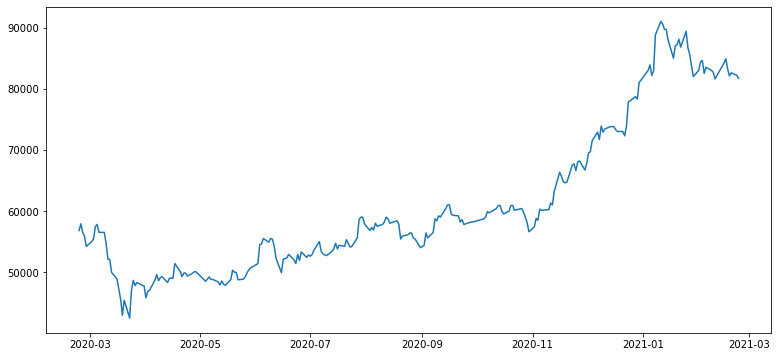

In [436]:
# 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.


plt.plot(ts)

## 2. 각종 전처리 수행

In [437]:
# 결측치 확인
ts1[ts1.isna()]

Series([], Name: Close, dtype: float64)

In [438]:
ts=ts.interpolate(method='time')

In [439]:
# 결측치(NAN) 유무 확인
print(ts[ts.isna()])

Series([], Name: Close, dtype: float64)


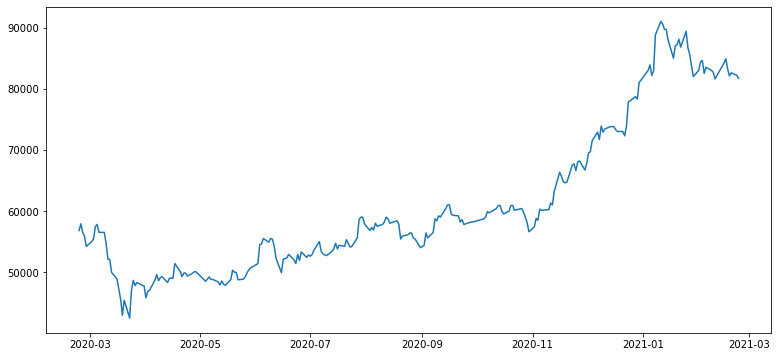

In [440]:
# 다시 시각화
plt.plot(ts)

In [441]:
# 로그 변환
ts_log = np.log(ts)

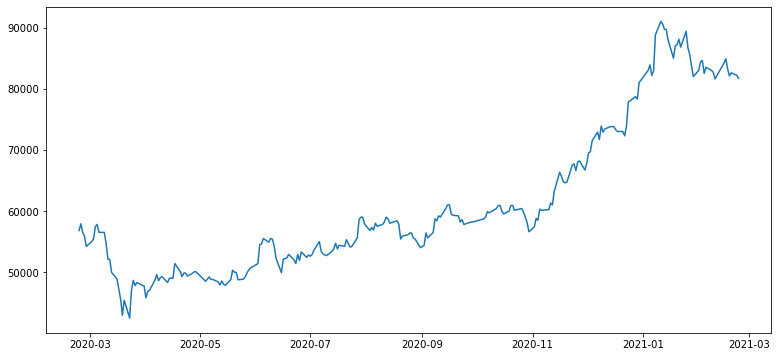

In [442]:
# 다시 시각화(2)
plt.plot(ts)

## 3. 시계열 안정성 분석

In [443]:
# 통계치 시각화

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

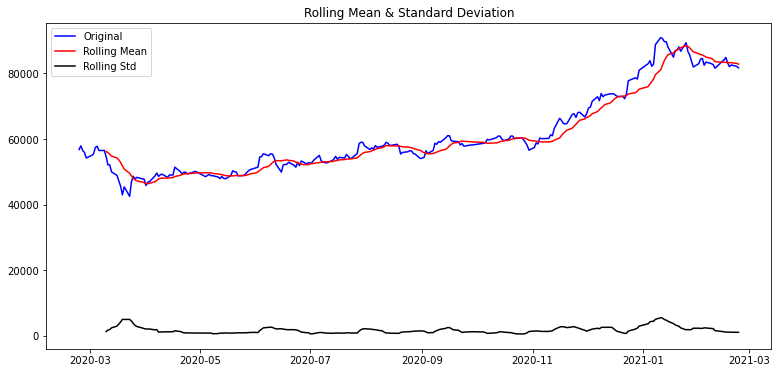

In [444]:
plot_rolling_statistics(ts, window=12)

In [445]:
#  Augmented Dickey-Fuller Test를 수행

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [446]:
augmented_dickey_fuller_test(ts1)

Results of Dickey-Fuller Test:
Test Statistic                   0.055885
p-value                          0.962917
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


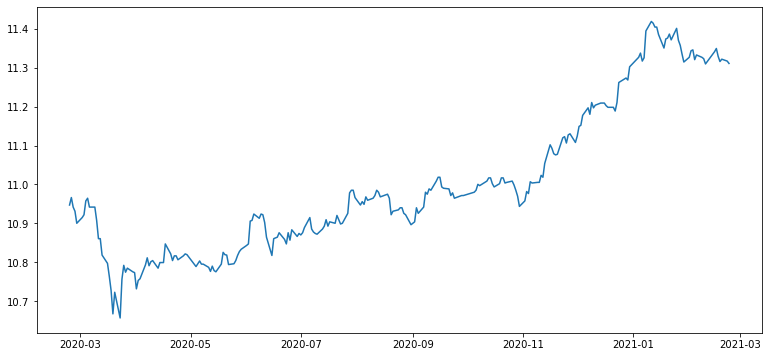

In [447]:
# 로그함수 변환
ts_log = np.log(ts)
plt.plot(ts_log)

In [448]:
# 로그 변환 효과 확인
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.120486
p-value                          0.947359
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


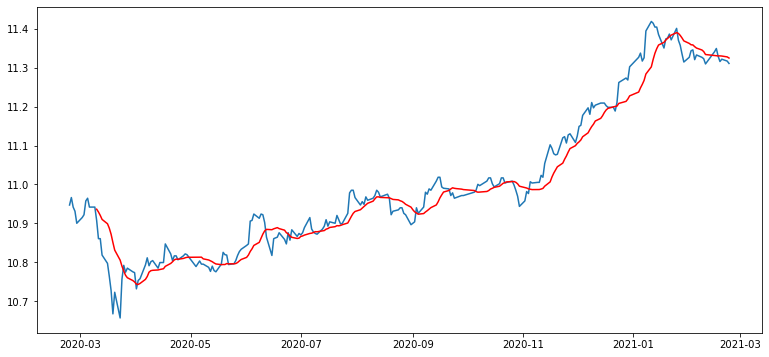

In [449]:
# Moving average 제거 - 추세(Trend) 상쇄하기
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [450]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-02-24         NaN
2020-02-25         NaN
2020-02-26         NaN
2020-02-27         NaN
2020-02-28         NaN
2020-03-02         NaN
2020-03-03         NaN
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-09         NaN
2020-03-10   -0.028816
2020-03-11   -0.068487
2020-03-12   -0.059691
2020-03-13   -0.091566
Name: Close, dtype: float64

In [451]:
# 결측치 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-03-10   -0.028816
2020-03-11   -0.068487
2020-03-12   -0.059691
2020-03-13   -0.091566
2020-03-16   -0.101662
2020-03-17   -0.123581
2020-03-18   -0.144565
2020-03-19   -0.183224
2020-03-20   -0.108205
2020-03-23   -0.148589
2020-03-24   -0.033580
2020-03-25    0.014454
2020-03-26    0.007912
2020-03-27    0.024629
2020-03-30    0.022360
Name: Close, dtype: float64

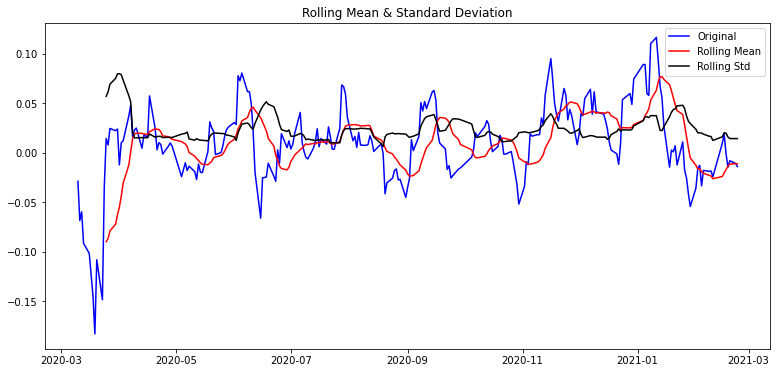

In [452]:
# 정성적 분석
plot_rolling_statistics(ts_log_moving_avg)

In [453]:
# 정량적 분석
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.015765
p-value                          0.001330
#Lags Used                       0.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


In [454]:
# window를 6으로 주면?
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

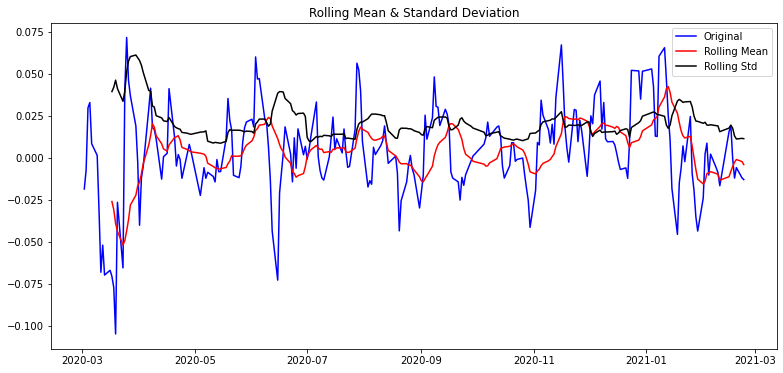

In [455]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [456]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                -6.776293e+00
p-value                        2.565738e-09
#Lags Used                     2.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


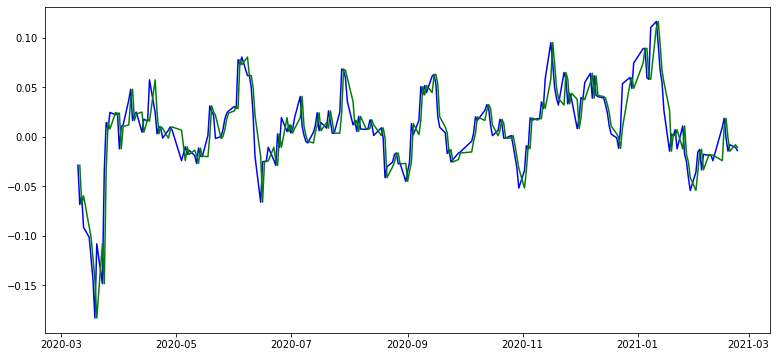

In [457]:
# 차분(Differencing) - 계절성(Seasonality) 상쇄하기
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

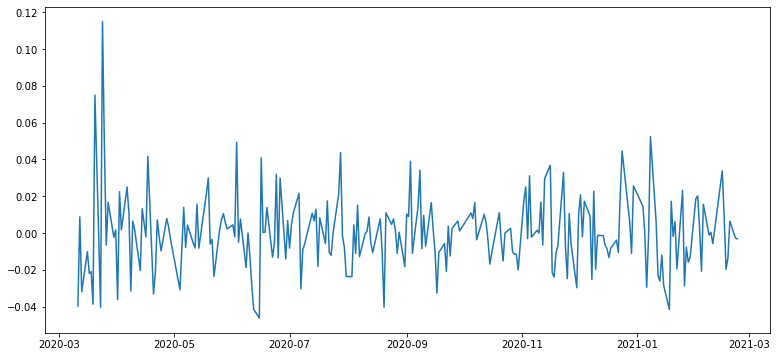

In [458]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

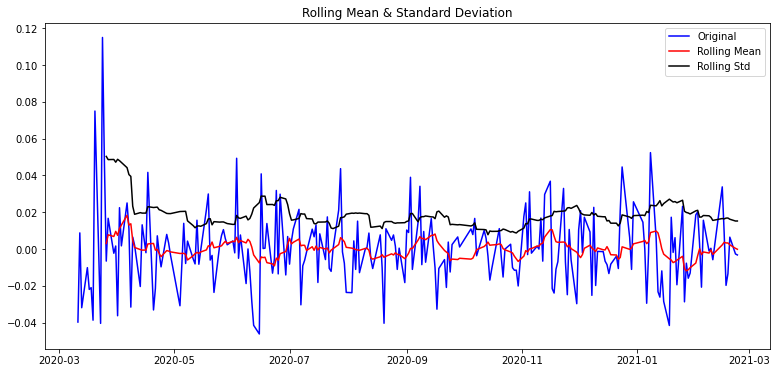

In [459]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [460]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.607723e+01
p-value                        5.426618e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


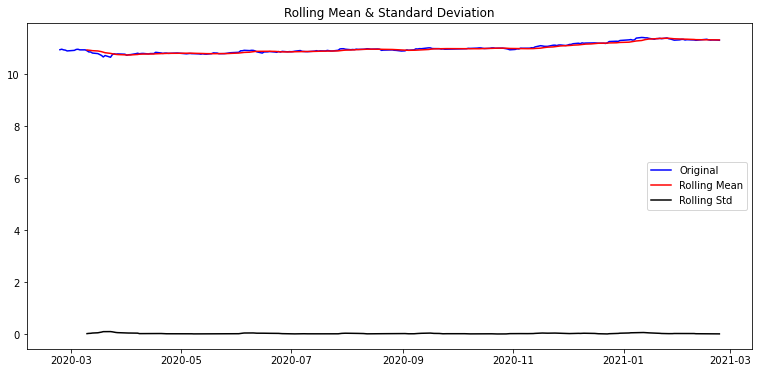

Results of Dickey-Fuller Test:
Test Statistic                  -0.120486
p-value                          0.947359
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


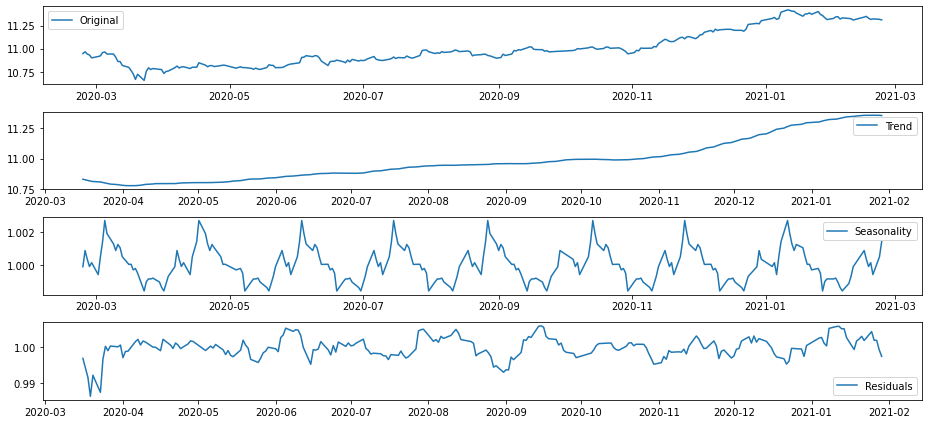

In [461]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

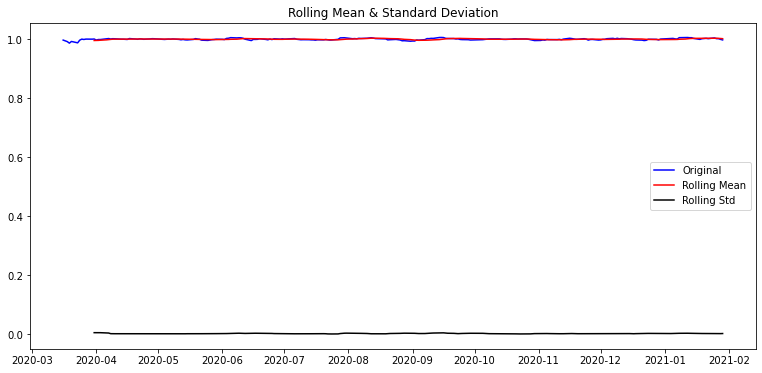

In [462]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [463]:
#Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.900911e+00
p-value                        2.779531e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

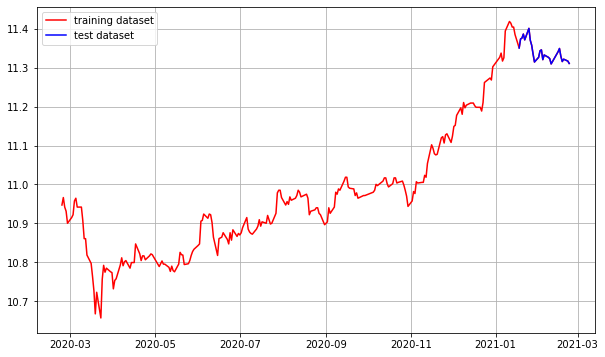

In [464]:
# 학습 및 테스트 데이터 분리
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [465]:
# 데이터셋 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-02-24    10.947292
2020-02-25    10.966473
Name: Close, dtype: float64
(223,)
(25,)


## 5. 적정 ARIMA 모수 찾기

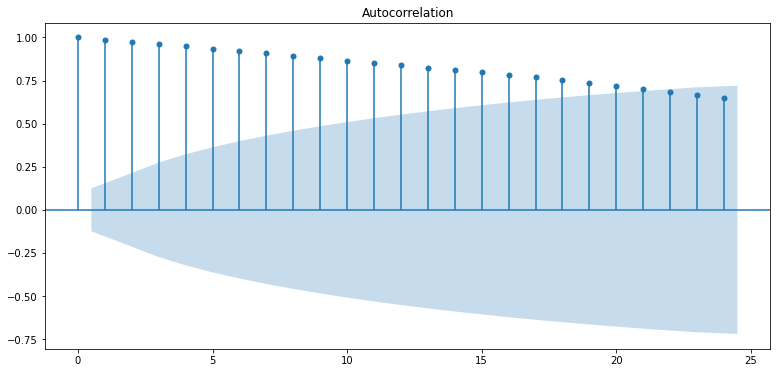

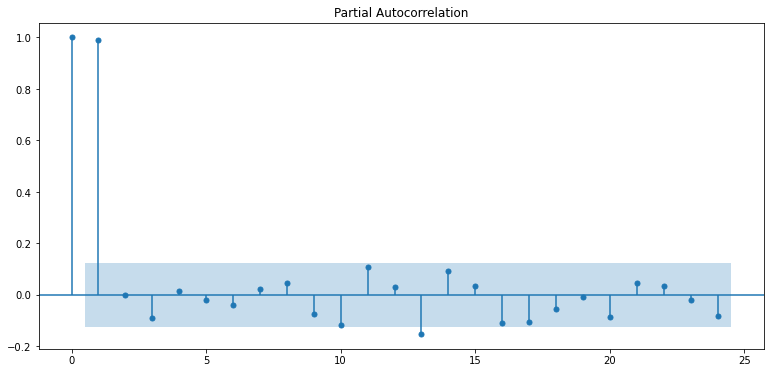

In [466]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.603651e+01
p-value                        5.977986e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.239657e+00
p-value                        1.898964e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


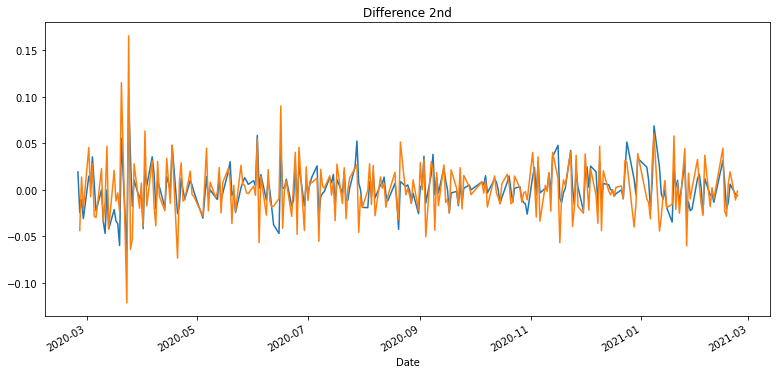

In [467]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

## 6. ARIMA 모델 훈련과 테스트

In [468]:
# ARIMA 모델 빌드와 훈련

from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 537.526
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 23 Feb 2021   AIC                          -1069.052
Time:                        15:31:30   BIC                          -1058.844
Sample:                             1   HQIC                         -1064.930
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0020      0.001      1.397      0.162      -0.001       0.005
ar.L1.D.Close    -0.0215      0.067     -0.321      0.748      -0.153       0.110
                                    Root

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no asso

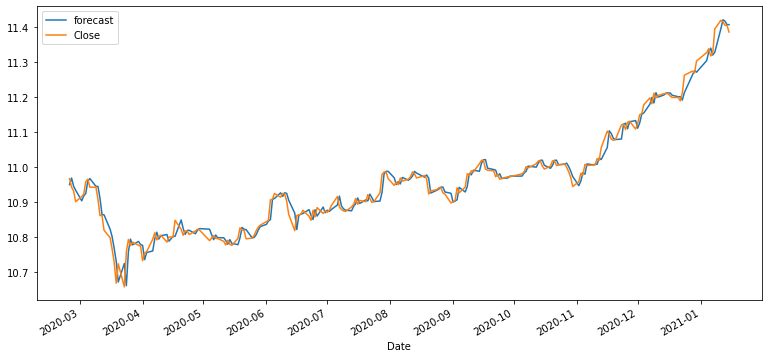

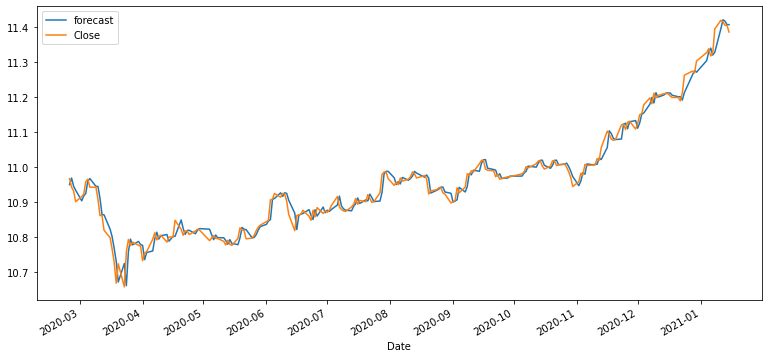

In [469]:
# ARIMA 모델이 잘 fit하는지 시각적으로 확인
fitted_m.plot_predict()

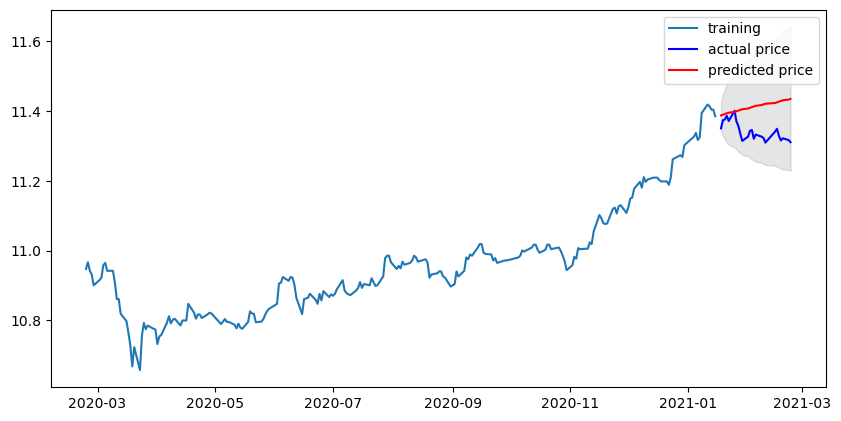

In [470]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [471]:
# 최종 예측 모델 정확도 측정(MAPE)

# MSE, MAE, RMSE, MAPE 계산

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  46645332.34902158
MAE:  6052.034938311396
RMSE:  6829.738819971199
MAPE: 7.27%


# 카카오 주식예측

## 1. 시계열 데이터 준비


In [597]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/KAKAO.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-02-24,184500.0,186000.0,182000.0,183500.0,183500.0,792733
1,2020-02-25,182000.0,186000.0,180000.0,185500.0,185500.0,596763
2,2020-02-26,183500.0,185500.0,181500.0,184000.0,184000.0,516378
3,2020-02-27,184000.0,185500.0,176500.0,178500.0,178500.0,785062
4,2020-02-28,174500.0,176500.0,170500.0,172000.0,172000.0,1022917


In [598]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-02-24,184500.0,186000.0,182000.0,183500.0,183500.0,792733
2020-02-25,182000.0,186000.0,180000.0,185500.0,185500.0,596763
2020-02-26,183500.0,185500.0,181500.0,184000.0,184000.0,516378
2020-02-27,184000.0,185500.0,176500.0,178500.0,178500.0,785062
2020-02-28,174500.0,176500.0,170500.0,172000.0,172000.0,1022917


In [599]:
ts2 = df['Close']
print(type(ts2))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-02-24    56800.0
2020-02-25    57900.0
2020-02-26    56500.0
2020-02-27    55900.0
2020-02-28    54200.0
Name: Close, dtype: float64

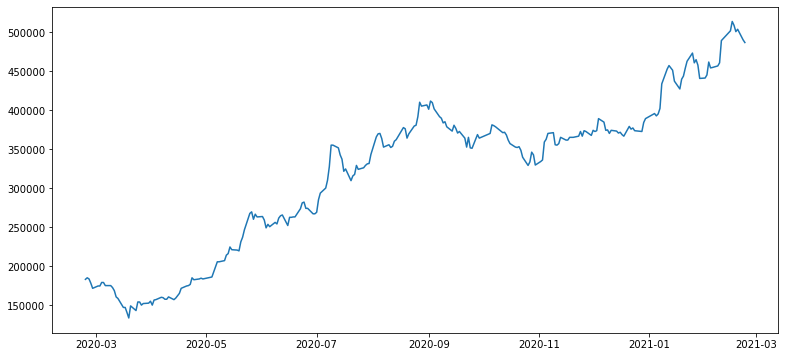

In [600]:
# 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.


plt.plot(ts2)

## 2. 각종 전처리 수행

In [601]:
# 결측치 확인
ts2[ts2.isna()]

Series([], Name: Close, dtype: float64)

In [602]:
ts2=ts2.interpolate(method='time')

In [603]:
# 결측치(NAN) 유무 확인
print(ts2[ts2.isna()])

Series([], Name: Close, dtype: float64)


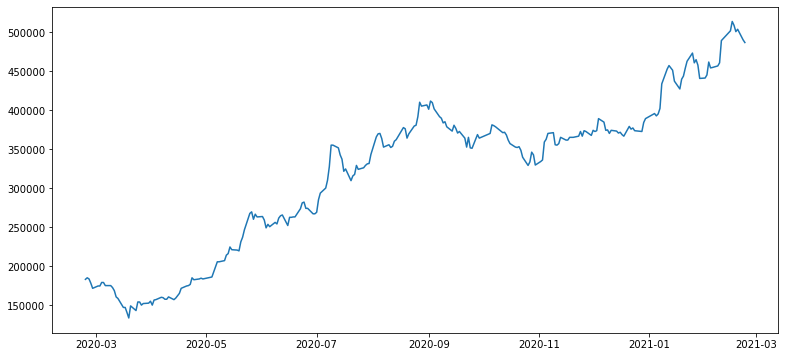

In [604]:
# 다시 시각화
plt.plot(ts2)

In [605]:
# 로그 변환
ts2_log = np.log(ts2)

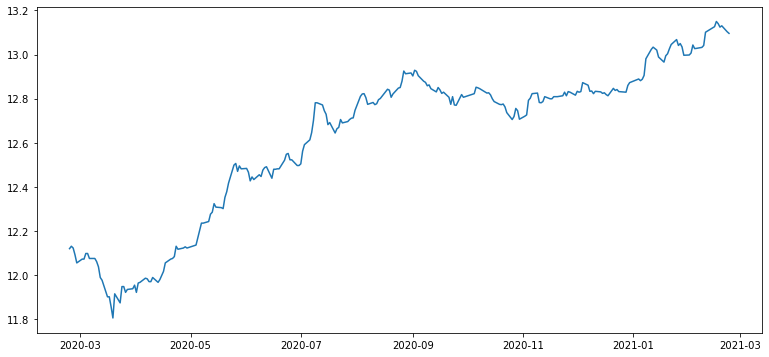

In [606]:
# 다시 시각화(2)
plt.plot(ts2_log)

## 3. 시계열 안정성 분석

In [607]:
# 통계치 시각화

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

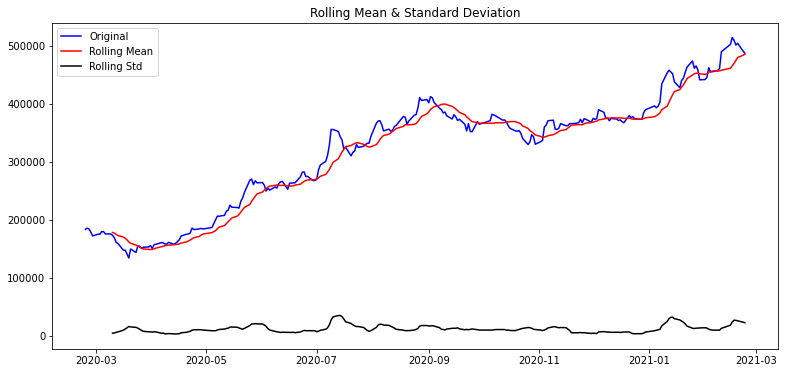

In [608]:
plot_rolling_statistics(ts2, window=12)

In [609]:
#  Augmented Dickey-Fuller Test를 수행

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [610]:
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                  -0.432599
p-value                          0.904512
#Lags Used                       1.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


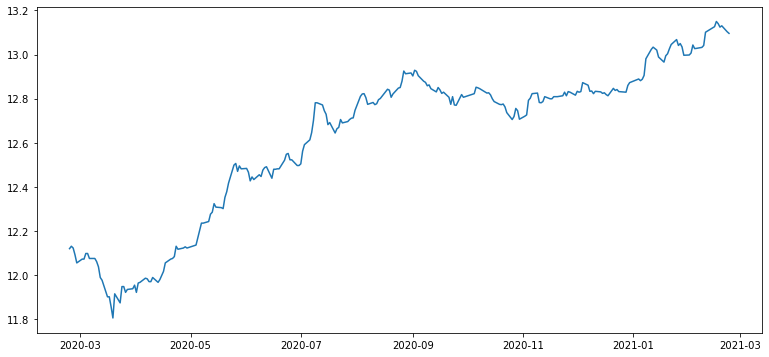

In [611]:
# 로그함수 변환
ts2_log = np.log(ts2)
plt.plot(ts2_log)

In [612]:
# 로그 변환 효과 확인
augmented_dickey_fuller_test(ts2_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.649566
p-value                          0.859384
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


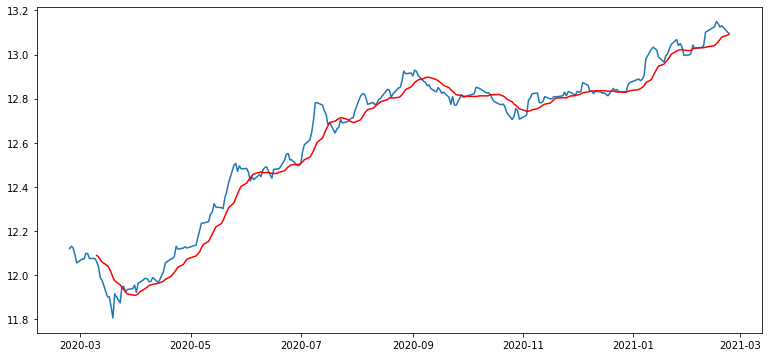

In [613]:
# Moving average 제거 - 추세(Trend) 상쇄하기
moving_avg = ts2_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts2_log)
plt.plot(moving_avg, color='red')

In [614]:
ts2_log_moving_avg = ts2_log - moving_avg # 변화량 제거
ts2_log_moving_avg.head(15)

Date
2020-02-24         NaN
2020-02-25         NaN
2020-02-26         NaN
2020-02-27         NaN
2020-02-28         NaN
2020-03-02         NaN
2020-03-03         NaN
2020-03-04         NaN
2020-03-05         NaN
2020-03-06         NaN
2020-03-09         NaN
2020-03-10   -0.028440
2020-03-11   -0.044973
2020-03-12   -0.081663
2020-03-13   -0.081994
Name: Close, dtype: float64

In [615]:
# 결측치 제거
ts2_log_moving_avg.dropna(inplace=True)
ts2_log_moving_avg.head(15)

Date
2020-03-10   -0.028440
2020-03-11   -0.044973
2020-03-12   -0.081663
2020-03-13   -0.081994
2020-03-16   -0.141174
2020-03-17   -0.128368
2020-03-18   -0.155434
2020-03-19   -0.184109
2020-03-20   -0.059412
2020-03-23   -0.081720
2020-03-24    0.002759
2020-03-25    0.013380
2020-03-26   -0.001241
2020-03-27    0.020522
2020-03-30    0.028042
Name: Close, dtype: float64

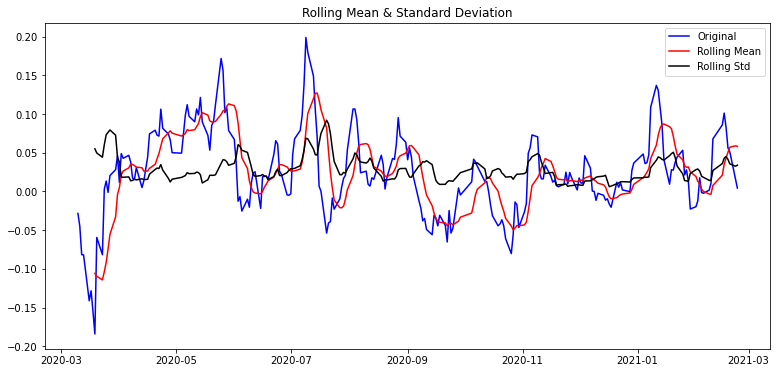

In [616]:
# 정성적 분석
plot_rolling_statistics(ts2_log_moving_avg)

In [617]:
# 정량적 분석
augmented_dickey_fuller_test(ts2_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.930052
p-value                          0.000030
#Lags Used                       2.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


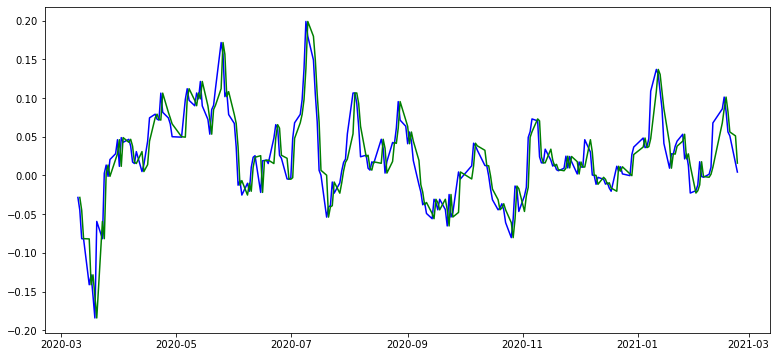

In [618]:
# 차분(Differencing) - 계절성(Seasonality) 상쇄하기
ts2_log_moving_avg_shift = ts2_log_moving_avg.shift()

plt.plot(ts2_log_moving_avg, color='blue')
plt.plot(ts2_log_moving_avg_shift, color='green')

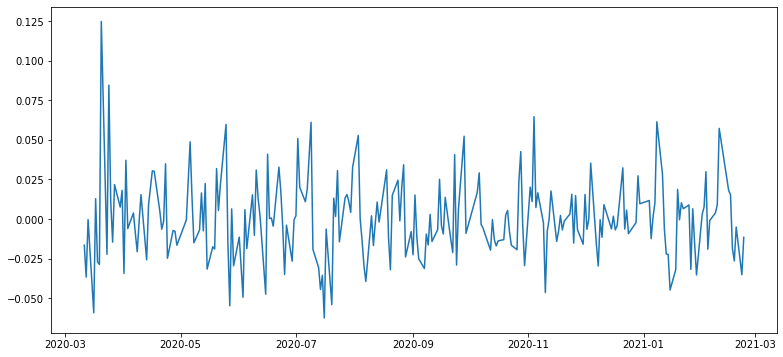

In [619]:
ts2_log_moving_avg_diff = ts2_log_moving_avg - ts2_log_moving_avg_shift
ts2_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts2_log_moving_avg_diff)

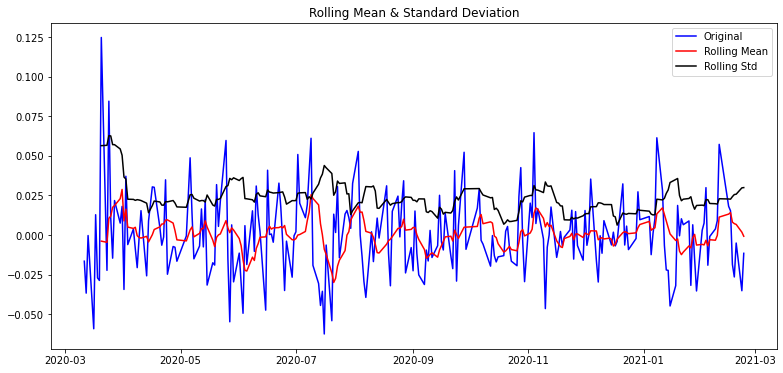

In [620]:
plot_rolling_statistics(ts2_log_moving_avg_diff)

In [621]:
augmented_dickey_fuller_test(ts2_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.412599e+01
p-value                        2.379088e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


# 정성적 그래프 분석
plot_rolling_statistics(ts2_log, window=16)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts2_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts2_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

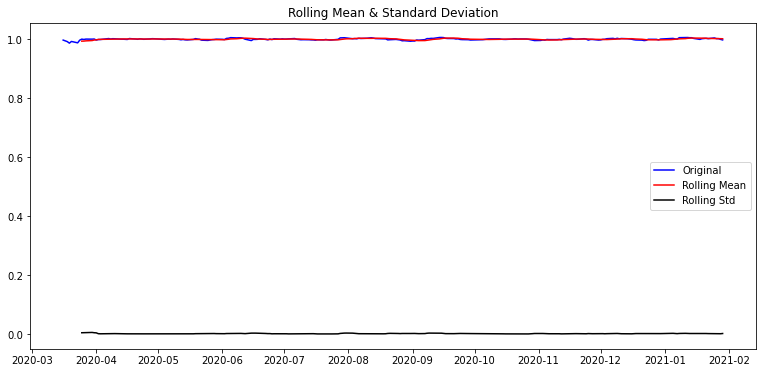

In [622]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [623]:
#Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -5.900911e+00
p-value                        2.779531e-07
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


## 4. 학습, 테스트 데이터셋 생성

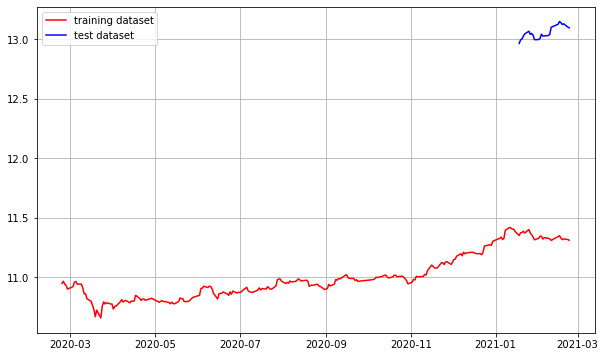

In [624]:
# 학습 및 테스트 데이터 분리
train_data, test_data = ts2_log[:int(len(ts2_log)*0.90)], ts2_log[int(len(ts2_log)*0.90):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [625]:
# 데이터셋 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-02-24    10.947292
2020-02-25    10.966473
Name: Close, dtype: float64
(223,)
(25,)


## 5. 적정 ARIMA 모수 찾기

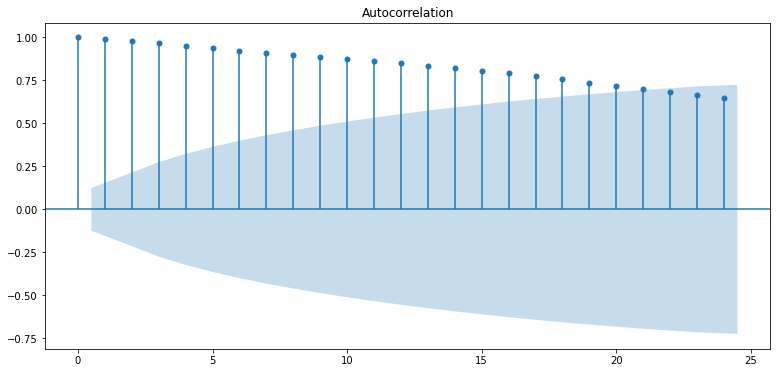

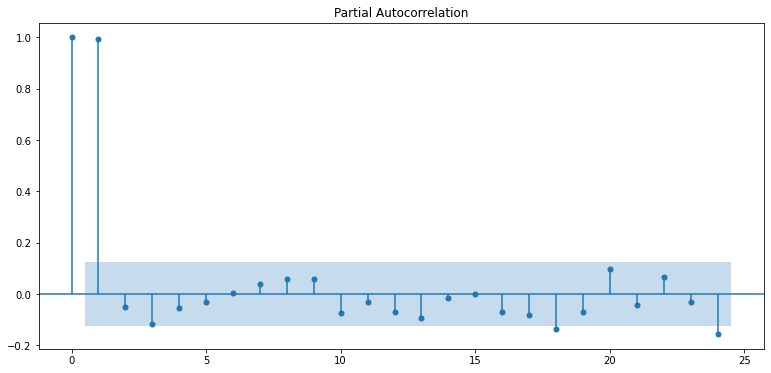

In [626]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.603651e+01
p-value                        5.977986e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.239657e+00
p-value                        1.898964e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.300000e+02
Critical Value (1%)           -3.459106e+00
Critical Value (5%)           -2.874190e+00
Critical Value (10%)          -2.573512e+00
dtype: float64


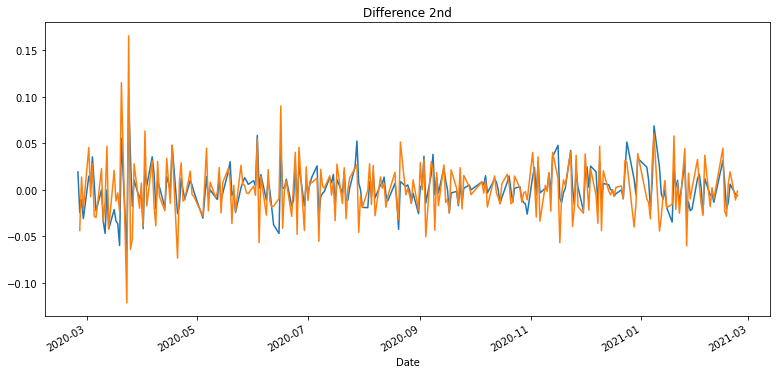

In [627]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 6. ARIMA 모델 훈련과 테스트

In [628]:
# ARIMA 모델 빌드와 훈련

from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 491.109
Method:                       css-mle   S.D. of innovations              0.026
Date:                Tue, 23 Feb 2021   AIC                           -976.218
Time:                        16:00:46   BIC                           -966.010
Sample:                             1   HQIC                          -972.097
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.002      2.020      0.043       0.000       0.008
ar.L1.D.Close     0.0805      0.067      1.200      0.230      -0.051       0.212
                                    Root

/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no asso

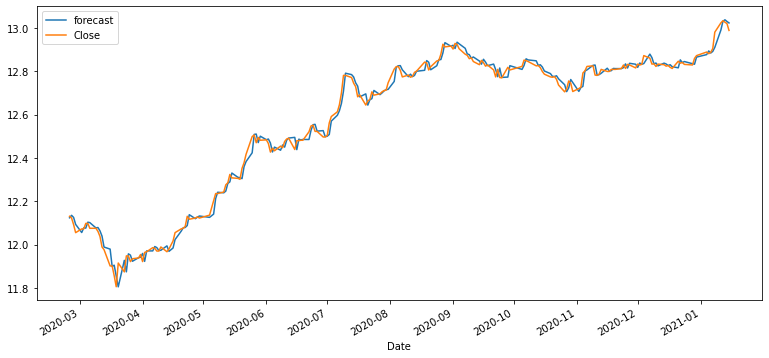

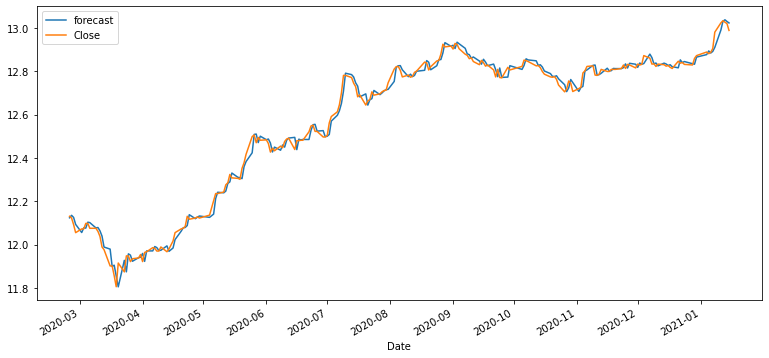

In [629]:
# ARIMA 모델이 잘 fit하는지 시각적으로 확인
fitted_m.plot_predict()

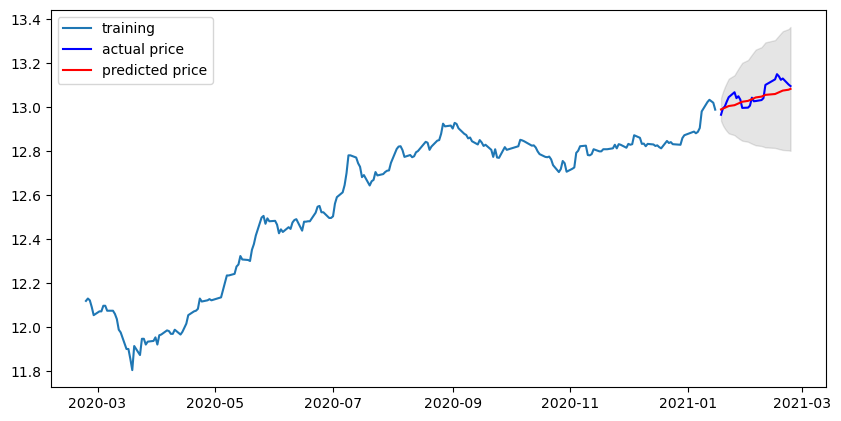

In [630]:
# forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [631]:
# 최종 예측 모델 정확도 측정(MAPE)

# MSE, MAE, RMSE, MAPE 계산

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  341056953.6456602
MAE:  14924.000732722425
RMSE:  18467.72735464925
MAPE: 3.11%


# 테슬라 주식예측

## 1. 시계열 데이터 준비

In [632]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/TSLA.csv' 
df = pd.read_csv(dataset_filepath) 
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [633]:
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500
2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500
2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000
2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000
2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500


In [634]:
ts3 = df['Close']
print(type(ts3))
ts3.head()

<class 'pandas.core.series.Series'>


Date
2010-06-29    4.778
2010-06-30    4.766
2010-07-01    4.392
2010-07-02    3.840
2010-07-06    3.222
Name: Close, dtype: float64

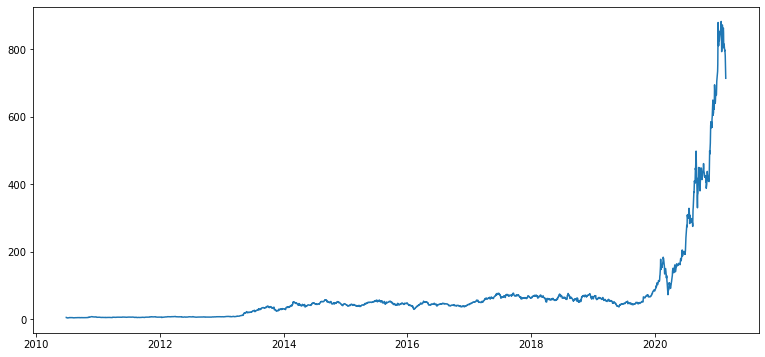

In [635]:
# 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.


plt.plot(ts3)

## 2. 각종 전처리 수행

In [636]:
# 결측치 확인
ts3[ts3.isna()]

Series([], Name: Close, dtype: float64)

In [637]:
ts3=ts3.interpolate(method='time')

In [639]:
# 결측치(NAN) 유무 확인
print(ts3[ts3.isna()])

Series([], Name: Close, dtype: float64)


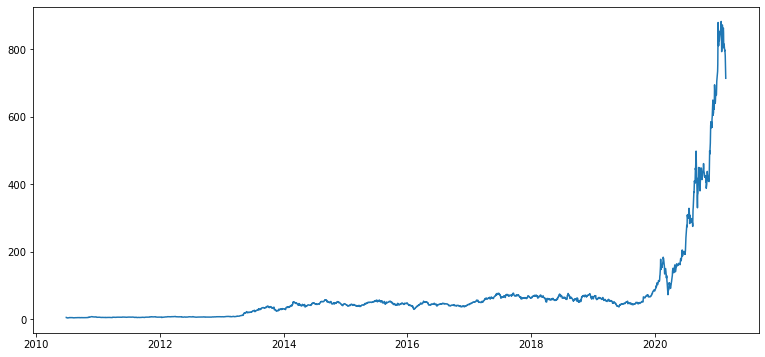

In [640]:
# 다시 시각화
plt.plot(ts3)

In [641]:
# 로그 변환
ts3_log = np.log(ts3)

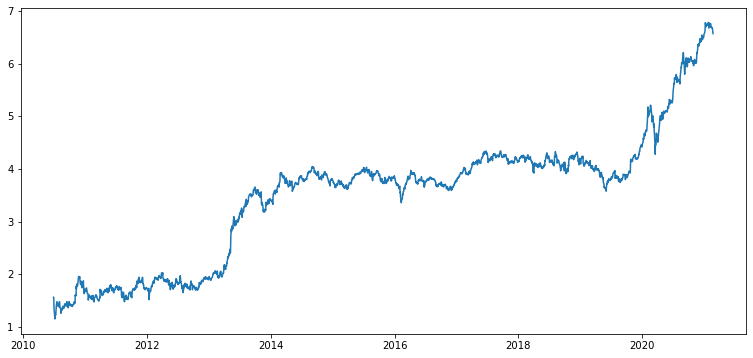

In [642]:
# 다시 시각화(2)
plt.plot(ts3_log)

## 3. 시계열 안정성 분석

In [643]:
# 통계치 시각화

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

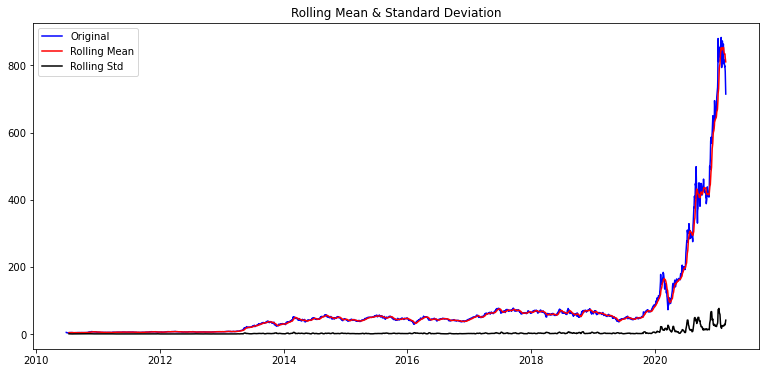

In [644]:
plot_rolling_statistics(ts3, window=12)

In [645]:
#  Augmented Dickey-Fuller Test를 수행

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [646]:
augmented_dickey_fuller_test(ts3)

Results of Dickey-Fuller Test:
Test Statistic                    2.480203
p-value                           0.999043
#Lags Used                       26.000000
Number of Observations Used    2654.000000
Critical Value (1%)              -3.432816
Critical Value (5%)              -2.862630
Critical Value (10%)             -2.567350
dtype: float64
